# $H^-$ Low Energy Beam Transport, aka. TB, but this includes TB & TD

**The following topics will be presented in this tutorial.**

* Changing a beam-line element's set point
* Predicting beam at another location in the beam line
* Saving beam for later use at another location in the beam line
* Analyzing and plotting the beam array at BLZ
* Graphing the beam envelope along the transport


Please refer to the LEBT_beam_initialization tutorial for details about setting up the boilerplate portion of the HPSim Python script, i.e., beam initialization. That code is included in the next cell. Although that portion of the script establishes the beamline and elements, beam distribution, space-charge and simulator, it does not ensure the beam line elements are at the desired set points. That is, the state of the beam transport elements should reflect the actual beam line configuration at the time the beam emittance used to create the above distribution was measured. It can also reflect any subsequent changes that were installed but with the same input beam distribution. However, making changes upstream of the beam starting point will likely produce a different beam distribution at the emittance station and result in erroneous simulations.


In [2]:
# initial section to import python modules required for simulations
import sys
import os
# define directory to packages and append to $PATH

par_dir = os.path.abspath(os.path.pardir)
print(par_dir)
pkg_dir = os.path.join(par_dir,"pylib")
print(pkg_dir)
sys.path.append(pkg_dir)

#import additional python packages
import numpy as np
import matplotlib.pyplot as plt
# import additional simulation packages
import hpsim as hps # hpsim provides access to the Python APIs used most often
#import HPSim as HPS # HPSim provides access to some addition lower-level functionality
from hpsim import sqldb as pydb
from hpsim import lcsutil as lcs
from hpsim import nputil as npu
GPU = 0
hps.set_gpu(GPU)

################################################################################
# install db's and connect to beamline
db_dir = par_dir + '/db'
lib_dir = par_dir + '/db/lib'
dbs = ['tbtd.db','dtl.db']
dbconn1 = hps.DBConnection(db_dir, dbs, lib_dir, 'libsqliteext.so')
dbconn1.print_dbs()
dbconn1.clear_model_index()
print("*** dB connection established ***")

################################################################################
# create beamline
bl = hps.BeamLine()
beamline = hps.get_element_list()
print("*** Beamline created ***")

################################################################################
# create H- beam
INPUT_BEAM_LOC = "TBEM01" #defined by input beam location
SIM_START = INPUT_BEAM_LOC
NOMINAL_W = 0.750
ENERGY_OFFSET = 0.0006
SYNCH_W = NOMINAL_W + ENERGY_OFFSET
NPART = 1024*64
beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=NPART) # H- beam
beam.set_dc( 0.411, 231.0, 0.002832, -1.211, 215.0, 0.003006, 180.0, 0.0, SYNCH_W) # TBEM01 #30599, 30600
beam.set_frequency(201.25)
# the next two lines of code are used to calculate the phase offset between Butt Line Zero (BLZ), which we 
# treat as a reference point with phase = 0 for the reference particle. We set the reference particle energy 
# to 0.750 MeV and its shift its phase accordingly.
betalambda = hps.betalambda(mass = beam.get_mass(), freq=beam.get_frequency(), w=SYNCH_W)
phi_offset = -hps.get_beamline_length(SIM_START,'BLZ')/betalambda *360
beam.set_ref_w(NOMINAL_W)
beam.set_ref_phi(phi_offset)
# Finally, we shift the phase of all particles in the distribution by the phi_offset amount. This scheme 
# would allow us to create a transverse beam at a different location but arrive at BLZ with the same phase.
beam.translate('phi', phi_offset)
beam.save_initial_beam()
print('*** ', SYNCH_W, ' MeV H- Beam created at', SIM_START, ' with ', NPART, 'particles ***')

################################################################################
# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print ( 'spch interval = ', spch.get_interval() )
print ( 'adj_bunch = ', spch.get_adj_bunch() )
# define at what energy simulation stops using adjacent bunches in SC calc
spch.set_adj_bunch_cutoff_w( 0.8 )
# remeshing factor determines how ofter the mesh gets recalc vs scaled for SC kick
spch.set_remesh_threshold( 0.02 )
print ( 'cutoff w= ', spch.get_adj_bunch_cutoff_w() )
print ( '*** Space Charge Initialized ***' )

################################################################################
# create simulator
sim = hps.Simulator(beam)
sim.set_space_charge('on')
print( '*** Simulator Initialized ***' )

################################################################################
# STANDARD AND REQUIRED STUFF ABOVE THIS LINE
################################################################################

/home/echuang/hpsim
/home/echuang/hpsim/pylib
GPU : NVIDIA RTX A6000
main -> /home/echuang/hpsim/db/tmp/tbtd.db
db1 -> /home/echuang/hpsim/db/tmp/dtl.db
*** dB connection established ***
*** Beamline created ***
***  0.7506  MeV H- Beam created at TBEM01  with  65536 particles ***
spch interval =  0.025
adj_bunch =  3
cutoff w=  0.8
*** Space Charge Initialized ***
*** Simulator Initialized ***
Beam frequency initialized to 201.25


### Changing a beam-line element's set point
HPSim uses SQL databases to store the beamline elements and their operational set points, the linac and transport design specifications, geometric information, and layout, and calibration factors and functions between the set points and physical characteristics of the elements. The databases are defined to cover geographic portions of the accelerator. For example, TBTD.db covers the low-energy beam transport from the beginning of the H- 750 keV transport to the end of the common transport immediately upstream of DTL tank 1. Just like in the Operations control room, the HPSim model is meant to be controlled through the operational set points of the beam line elements. For example, TBQL001V01 represents the first quadrupole lens in H- low-energy beam transport, TB. Its geometry and location in TB, along with the conversion between the integral GdL and the magnet current as specificed by the precision voltage read from an inline shunt on the current lead of TBQL001V01, is stored in the database, tbtd.db . To control the intensity of TBQL01's magnetic field and therefore its focusing strength, you adjust the epics_channel TBQL001V01 via a knob in the control rooom or via a value defined in the database file in the model. Nominally setting it to the same value as was read out at the time the emittance measurement was made.

Changes to the EPICS_channels in the tbtd.db file can be made in a few ways. One can use a GUI interface, e.g. tksqlite.tcl to access the database and display. An example of this for the TBTD.db file is shown below.
![tbtd-2022 database file as seen with TkSQLite GUI](figures/tbtd-2022.png)
An advantage of using this interface is that the whole database is available for viewing and all EPICS channels in the database are available for changing their values. You may choose to use a different viewer or GUI as well. 

Another approach would be to access the database through the Python script. You can use the HPSim Python API `set_db_epics` to change the value of an EPICS PV in the database. E.g. placing this line of code `hps.set_db_epics('TBQL001V01', 8.420)` in your Python script before the actual simulation is done, would change TBQL001V01 to a set point of 8.420 .

Finally, a method is being developed to use CAFlux, to update all the EPICS pv's in the database to values at a specific time in the past. This will be presented in a different tutorial.


### Predicting beam at another location in the beam line

It is very straight forward to simulate the beam at a downstream location in the beam line. Once you have established the boilerplate code, i.e., what's shown in cell [1], and the set points of all the beam line elements have been updated, the simulation requires just few lines of code. For example, say you have created a beam distribution at TBEM01 and you would like to see what the beam looks like at TBEM02. You can use the following code to perform that simulation, print and plot analysis results. Use variable `SIM_STOP` to define the name of the beam line element where you want the beam simulation to stop. This element name must match exactly what is in the database, otherwise you will get an error. The variable `ENERGY_CUTOFF` is used to set a lower threshold above which particles will be included in the plots and output. But in order to use it, you must use the `beam.get_mask_with_limits` as shown. This mask is then used along with `get_good_mask`, which returns a mask that only includes the particles that have not been lost, i.e., struck an aperature or pipe, to return a mask with particles above the energy cutoff and that have not struck the wall. You can use the mask in the `beam.print_results` API and in the plotting APIs. Masks are a very convenient way of including particles that do and excluding those that don't satisfy certain criteria from the post analyses results and graphs. You must update the mask after a simulation to ensure is reflects the lastest state of the beam. **BEWARE** the state of the "BEAM" for the next calculation is where is was last, including after any simulations. In a jupyter notebook, it is easy to repeatedly run a cell of code multiple times in sucession. Unless you have previously saved the beam, e.g., `beam.save_initial_beam()` after creating it, and then restore it using `beam.restore_initial_beam()` before the `beam.simulate( SIM_START, SIM_STOP )` command, running the cell of code again and again will produce nonsensical results. That's because the output beam at location `SIM_STOP` will be used as the input beam at `SIM_START`, which is probably not what you wanted.

Below is additional code that simulates the previously generated TBEM01 H- beam distribution at TBEM02 and prints and plots the results. The `beam.print_results()` provides 6D beam information, i.e., centroids, sigmas, emittances, number good and lost, etc. The plotting routines are from the `BeamPlot` class of hpsim. Please refer to the HPSim User Guide for details on how to use these API's.

*** Input Beam ***
TBEM01
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** No Mask applied ***
Number of macroparticles(good) = 65536
Number of macroparticles lost  = 0
Ref part. 
 phi = -68932.8563 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :       0.0027        0.3326 cm 
xp :      -0.0079        1.5512 mr 
y  :       0.0002        0.3290 cm 
yp :      -0.0053        2.4045 mr 
phi:  -68932.8508      103.9207 deg
w  :       0.7506        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.4167      0.2323      0.4763     0.01904
y :     -1.2244      0.2163      0.5005     0.02001
z :     -0.0000 44339824.0863      0.0002


*** Starting Simulation ***

*** Output Beam ***
TBEM02
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** Mask applied ***

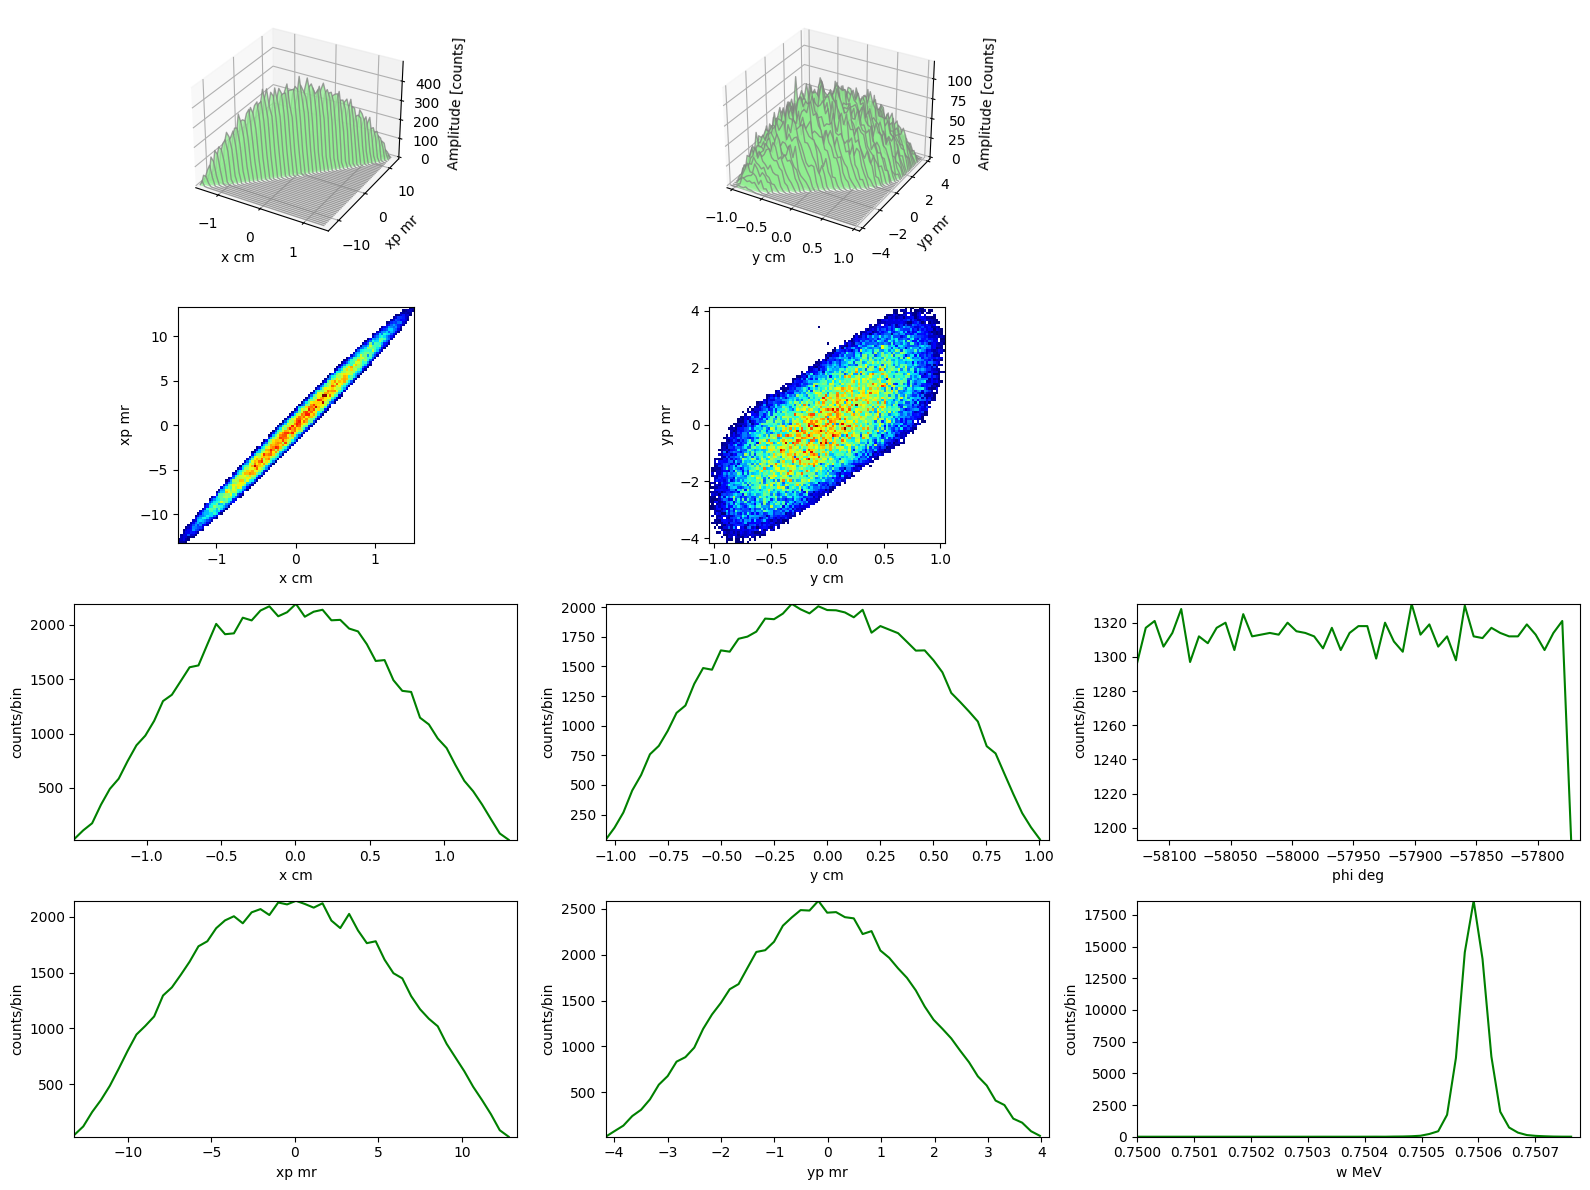

In [4]:
beam.restore_initial_beam() #added to ensure that you always start this simulation with the initial beam
SIM_START = INPUT_BEAM_LOC
SIM_STOP = 'TBEM02'
ENERGY_CUTOFF = 0.0

print ('*** Input Beam ***')
print ( SIM_START )
print ('w/user units')
beam.print_results()

print ("*** Starting Simulation ***\n")
sim.simulate(SIM_START, SIM_STOP)

# determine mask of particles used in analysis and plotting
wmask = beam.get_mask_with_limits('w', lolim = ENERGY_CUTOFF)
mask = beam.get_good_mask(wmask)

# analyze beam and print results
print('*** Output Beam ***')
print( SIM_STOP )
print('w/user units')
beam.print_results(mask)

# create output plot
plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_START)
plot.iso_phase_space('xxp', beam, mask, 1)
plot.iso_phase_space('yyp', beam, mask, 2)

plot.hist2d_phase_space('xxp', beam, mask, 4)
plot.hist2d_phase_space('yyp', beam, mask, 5)

plot.profile('x', beam, mask, 7, 'g-')
plot.profile('y', beam, mask, 8, 'g-')
plot.profile('phi', beam, mask, 9, 'g-')

plot.profile('xp', beam, mask, 10, 'g-')
plot.profile('yp', beam, mask, 11, 'g-')
plot.profile('w', beam, mask, 12, 'g-',ylog=False)

plot.show()


The above results could then be compared with actual measurements of the H- beam at TBEM02.

### Saving beam for later use at another location in the beam line

HPSim is flexible and can accept or use an input beam defined at any location within the database of elements. However, to do this one needs knowledge of the beam parameters to create it or a file of 6D particle coordinates to read into the beam object. Both of these require either measurements or simulated results. The LEBT_beam_initialization tutorial presents how to do this for one particular emittance station where the beam is still DC. The others are the same. However, if you want to create an input beam at a location in the LEBT downstream of an active RF cavity, e.g., prebuncher, one must be careful. The buncher will impart an energy modulation on the beam and it will not be well represented by a 6D waterbag distribution. It is better to create the input beam at a location upstream of an RF cavity then use the simulation to produce a beam with that modulation present at the downstream location, and then save and reuse the output beam at a later time. For example, let say we want to start with beam at TBEM01 and use the setting of the prebuncher and main bunchers to bunch the beam, but then save it at TDEM01 for use in transverse matching the beam at BLZ using the TDQL's. This approach saves performing the simulation from TBEM01 to BLZ each time, when the only devices that are changing are the TDQL's. So one simply simulates the initial beam from TBEM01 to TDEM01 and then saves the output as an intermediate beam using the API `beam.save_intermediate_beam()`. One then updates the starting location of the simulation to TDEM01 and restores the intermediate beam with the `beam.restore_intermediate_beam()` API for subsequent use, say in a loop to match the beam at BLZ. The code is shown below.

In [6]:
beam.restore_initial_beam() #added to ensure that you always start this simulation with the initial beam
SIM_START = INPUT_BEAM_LOC
SIM_STOP = 'TDEM01'
ENERGY_CUTOFF = 0.0

print ('*** Input Beam ***')
print ( SIM_START )
print ('w/user units')
beam.print_results()

print ("*** Starting Simulation ***\n")
sim.simulate(SIM_START, SIM_STOP)

print ('*** Output Beam ***')
print ( SIM_STOP )
print ('w/user units')
beam.print_results()

# save the output beam as the intermediate beam
beam.save_intermediate_beam()

# define a new starting location
SIM_START_INTERMEDIATE = SIM_STOP
SIM_STOP_INTERMEDIATE = 'BLZ'

# loop the simulation from TDEM01 to BLZ a total of three times
for n in [1, 2, 3]:
    beam.restore_intermediate_beam() # restore beam at TDEM01 prior to each pass thru the loop
    print ('*** Input Beam ***')
    print ( SIM_START_INTERMEDIATE )
    print ('w/user units')
    beam.print_results()
    #
    # change TDQL's here
    #
    sim.simulate( SIM_START_INTERMEDIATE, SIM_STOP_INTERMEDIATE )
    #
    # analyze, print or graph results
    # adjust TDQL's as needed
    #
    print ('*** Output Beam ***')
    print ( SIM_STOP_INTERMEDIATE )
    print ('w/user units')
    beam.print_results()
print("loop complete")


*** Input Beam ***
TBEM01
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** No Mask applied ***
Number of macroparticles(good) = 65536
Number of macroparticles lost  = 0
Ref part. 
 phi = -68932.8563 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :       0.0027        0.3326 cm 
xp :      -0.0079        1.5512 mr 
y  :       0.0002        0.3290 cm 
yp :      -0.0053        2.4045 mr 
phi:  -68932.8508      103.9207 deg
w  :       0.7506        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.4167      0.2323      0.4763     0.01904
y :     -1.2244      0.2163      0.5005     0.02001
z :     -0.0000 44339824.0863      0.0002


*** Starting Simulation ***

*** Output Beam ***
TDEM01
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 14.85 mA
Frequency = 201.250 MHz
*** No Mask applied 

### Analyzing and plotting the beam array at BLZ

It is often very helpful to see the DTL input beam, especially the longitudinal aspects. This can be done by first simulating the beam at Butt Line Zero, BLZ, which is where the upstream RF wall in DTL TANK 1 is located. The code example and results for this section is shown below.

*** Input Beam ***
TBEM01
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 15.00 mA
Frequency = 201.250 MHz
*** No Mask applied ***
Number of macroparticles(good) = 65536
Number of macroparticles lost  = 0
Ref part. 
 phi = -68932.8563 deg
   w =     0.7500 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :       0.0027        0.3326 cm 
xp :      -0.0079        1.5512 mr 
y  :       0.0002        0.3290 cm 
yp :      -0.0053        2.4045 mr 
phi:  -68932.8508      103.9207 deg
w  :       0.7506        0.0000 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      0.4167      0.2323      0.4763     0.01904
y :     -1.2244      0.2163      0.5005     0.02001
z :     -0.0000 44339824.0863      0.0002


*** Starting Simulation ***

*** Output Beam ***
BLZ
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = -1
Ib = 13.51 mA
Frequency = 201.250 MHz
*** No Mask applied ***

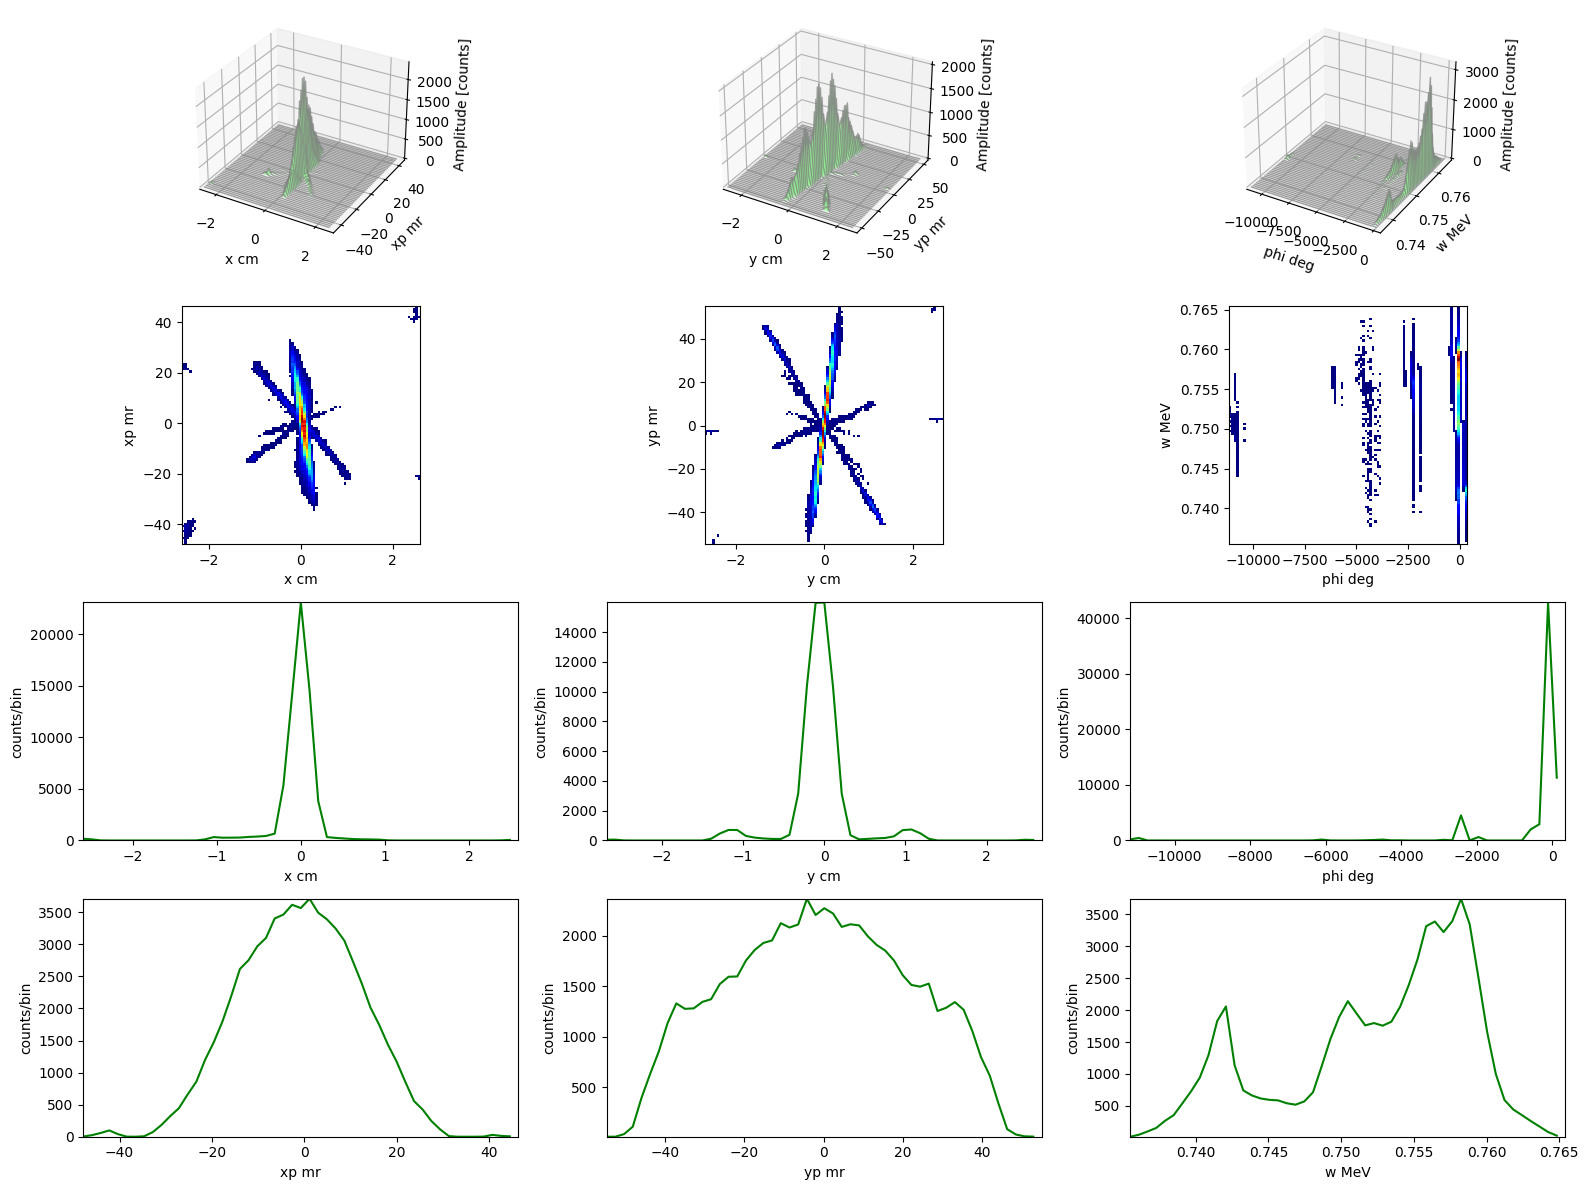

In [7]:
beam.restore_initial_beam() #added to ensure that you always start this simulation with the initial beam
SIM_START = INPUT_BEAM_LOC
SIM_STOP = 'BLZ'
ENERGY_CUTOFF = 0.0

print ('*** Input Beam ***')
print ( SIM_START )
print ('w/user units')
beam.print_results()

print ("*** Starting Simulation ***\n")
sim.simulate( SIM_START, SIM_STOP )

print ('*** Output Beam ***')
print ( SIM_STOP )
print ('w/user units')
beam.print_results()

# create output plot
plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_START)
plot.iso_phase_space('xxp', beam, mask, 1)
plot.iso_phase_space('yyp', beam, mask, 2)
plot.iso_phase_space('phiw', beam, mask, 3)

plot.hist2d_phase_space('xxp', beam, mask, 4)
plot.hist2d_phase_space('yyp', beam, mask, 5)
plot.hist2d_phase_space('phiw', beam, mask, 6)

plot.profile('x', beam, mask, 7, 'g-')
plot.profile('y', beam, mask, 8, 'g-')
plot.profile('phi', beam, mask, 9, 'g-')

plot.profile('xp', beam, mask, 10, 'g-')
plot.profile('yp', beam, mask, 11, 'g-')
plot.profile('w', beam, mask, 12, 'g-',ylog=False)

plot.show()


### Graphing the beam envelope along the transport
HPSim is used to simulate the beam evolution from element A to element B. At the end of element B, the beam can be analyzed for different quantities, e.g., the transverse beam size. One can produce a graph of the beam size at the end of various beam elements by performing a simulation in many smaller sequential steps. An example of code that does this is shown below.

The `FILTER_BEAM` logical variable can be used to first determine which particles would make it to the end of the overall simulation by creating a mask from those good particles, then restarting the simulation and applying this mask to only analyze or plot the particles that make it all the way to the end. That variable is turned off, i.e., set to `FALSE` for this example.

The code steps through each element between the first and last elements and checks to see if it is one of the types in the list of `VALID_ENVELOPE_ELEMENTS`. If so, then it stores the various beam quantities in an output array for later plotting. Lastly is makes a graph of the quantities of interest vs. distance from the start of the simulation. The code and results are shown below.


TBEM01
spch_comp_2
TBDR06
TBQL02V1
TBDR07
TBQL02V2
TBDR08
TBQL02V3
TBDR09
TBEM01COL
TBDR10
TBBA01
TBDR11
TBSM02X
TBSM02Y
TBDR12
TBDR13
TBDR14
TBDR15
TBDR16
TBDR17
TBBA02
TBDR18
TBEM02
spch_comp_3
TBDR19
TBQL03V1
TBDR20
TBQL03V2
TBDR21
TBEM02COL
TBDR22
TBSM03X
TBSM03Y
TBDR23
TBBM01
TBDR24
TBFJ01
TBDR25
TBQL04V1
TBDR26
TBQL04V2
TBDR27
TBEM03
spch_comp_4
TBDR28
TBSM04X
TBSM04Y
TBDR29
TBDB01
TBDR30
TBDB02
TBDR31
TBBA04
TBDR32
TBSM05X
TBSM05Y
TBDR33
TBEM03COL
TBDR34
TBQL05V1
TBDR35
TBQL05V2
TBDR36
TBQL05V3
TBDR37
TBQL05V4
TBDR38
TBFJ02
TBDR39
TBDR40
TBSM06X
TBSM06Y
TBDR41
TBEM04
spch_comp_5
TBDR42
TBQL06V1
TBDR43
TBQL06V2
TBDR44
TBEM04COL
TBDR45
TBFJ03
TBDR46
TBQL06V3
TBDR47
TBQL06V4
TBDR48
TBSM07X
TBSM07Y
TBDR49
TDBM01
TDDR01
TDBA01
TDDR02
: Reset Simulation variables
: Whole simulation 0.0658 [sec]

: start index 11 < prev_end 34. Reset
: Reset Simulation variables
: Whole simulation 0.0658 [sec]

: start index 11 < prev_end 34. Reset
: Reset Simulation variables
: Whole simulation 0.3966

/home/bizon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use `.FigureManagerBase.set_window_title` or GUI-specific methods instead.


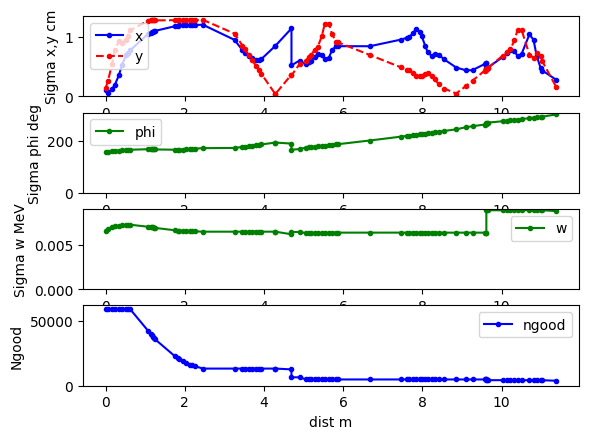

In [10]:
SIM_START = INPUT_BEAM_LOC #defined by input beam
SIM_STOP = 'BLZ'
ENERGY_CUTOFF = 0.0
BEAM = '-'
VALID_ENEVELOPE_ELEMENTS = ['drift', 'quad', 'dipole', 'buncher', 'dtl_gap', 'ccl_gap']

# filter beam will first simulate to the end, determine the mask based upon the
# energy threshold & good, then use this mask to plot envelopes
FILTER_BEAM = False

if FILTER_BEAM:
    sim.simulate(SIM_START, SIM_STOP)
    wmask = beam.get_mask_with_limits('w', lolim = ENERGY_CUTOFF)
    gmask = beam.get_good_mask(wmask)
    mask = gmask
    beam.restore_initial_beam()

beamline = hps.get_element_list(SIM_START, SIM_STOP)
# ztot, ngood, sigx, sigy, sigphi, sigw
beam_output = np.zeros((len(beamline), 6))
loc_output = np.chararray(len(beamline), itemsize=10)
loc_output[:]=''
num_output = np.zeros(len(beamline), dtype=np.int32)

if not FILTER_BEAM:
    mask = beam.get_good_mask(mask = None)

ztot = 0.0
num_output[0] = 0
loc_output[0] = SIM_START
beam_output[0,0:6] = [ztot, len(mask), beam.get_sig('x', mask), \
                          beam.get_sig('y', mask), beam.get_sig('phi', mask), \
                          beam.get_sig('w', mask)]

if not FILTER_BEAM:
    mask = None

try:
    nloc = 0
    nmax = nloc
    for num, elem in enumerate(beamline):
# simulate here
        print ( elem )
        sim.simulate(elem, elem)
        ztot = ztot +  hps.BeamLine.get_element_length(elem)
        if hps.get_db_model(elem,'model_type') in VALID_ENEVELOPE_ELEMENTS:
            if not FILTER_BEAM:
                mask = beam.get_good_mask(mask=None)

            nloc += 1 
            beam_output[nloc,0:6]= [ztot, len(mask), beam.get_sig('x', mask), \
                           beam.get_sig('y', mask), beam.get_sig('phi', mask), \
                           beam.get_sig('w', mask)]
            loc_output[nloc]= elem
            num_output[nloc] = num
            nmax = nloc
        #end loop
finally:
    num = num_output
    elem = loc_output
    ztot = beam_output[0:nmax,0]
    ngood = beam_output[0:nmax,1]
    sigx = beam_output[0:nmax,2]
    sigy = beam_output[0:nmax,3]
    sigphi = beam_output[0:nmax,4]
    sigw = beam_output[0:nmax,5]

    fig2 = plt.figure()
    title = "H{0} from {1} to {2}".format(\
        BEAM, SIM_START, SIM_STOP)
    fig2.canvas.set_window_title(title)

    a1 = fig2.add_subplot(411)
    a1.plot(ztot, sigx, 'b.-')
    a1.plot(ztot, sigy, 'r.--')
    a1.set_ylim(ymin=0)
    a1.legend(['x','y'])
    a1.set_xlabel('dist m') #elem num')
    a1.set_ylabel('Sigma x,y cm')

    a2 = fig2.add_subplot(412)
    a2.plot(ztot, sigphi, 'g.-')
    a2.set_ylim(ymin=0.0)
    a2.legend(['phi'])
    a2.set_xlabel('dist m') #elem num')
    a2.set_ylabel('Sigma phi deg')

    a3 = fig2.add_subplot(413)
    a3.plot(ztot, sigw, 'g.-')
    a3.set_ylim(ymin=0.0)
    a3.legend(['w'])
    a3.set_xlabel('dist m') #elem num')
    a3.set_ylabel('Sigma w MeV')

    a4 = fig2.add_subplot(414)
    a4.plot(ztot, ngood, 'b.-')
    a4.set_ylim(ymin=0.0)
    a4.legend(['ngood'])
    a4.set_xlabel('dist m') #elem num')
    a4.set_ylabel('Ngood')

    plt.show()

**End of TBTD_transport tutorial**